# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources (README.md file)
- Happy learning!

In [4]:
# Import numpy and pandas

import numpy as np
import pandas as pd

# Challenge 1 - Loading and Evaluating The Data

In this lab, we will look at a dataset of sensor data from a cellular phone. The phone was carried in the subject's pocket for a few minutes while they walked around.

To load the data, run the code below.

In [5]:
# Run this code:

sensor = pd.read_csv('../sub_1.csv')
sensor.drop(columns=['Unnamed: 0'], inplace=True)

Examine the data using the `head` function.

In [6]:
# Your code here:

sensor.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Check whether there is any missing data. If there is any missing data, remove the rows containing missing data.

In [7]:
# Your code here:
sensor.isna().sum(axis=0)




attitude.roll         0
attitude.pitch        0
attitude.yaw          0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
dtype: int64

How many rows and columns are in our data?

In [8]:
# Your code here:
sensor.shape


(1751, 12)

To perform time series analysis on the data, we must change the index from a range index to a time series index. In the cell below, create a time series index using the `pd.date_range` function. Create a time series index starting at 1/1/2018 00:00:00 and ending at 1/1/2018 00:29:10. The number of periods is equal to the number of rows in `sensor`. The frequency should be set to `infer`.

In [9]:
# Your code here:
sensor["date"] = pd.date_range("1/1/2018 00:00:00", "1/1/2018 00:29:10", periods = sensor.shape[0])



Assign the time series index to the dataframe's index.

In [10]:
# Your code here:

sensor.index = sensor["date"]

Our next step is to decompose the time series and evaluate the patterns in the data. Load the `statsmodels.api` submodule and plot the decomposed plot of `userAcceleration.x`. Set `freq=60` in the `seasonal_decompose` function. Your graph should look like the one below.

![time series decomposition](../images/tsa_decompose.png)

In [11]:
# Your code here:
from statsmodels.tsa.seasonal import seasonal_decompose

In [12]:
res = seasonal_decompose(sensor["userAcceleration.x"], freq = 60, model="additive")

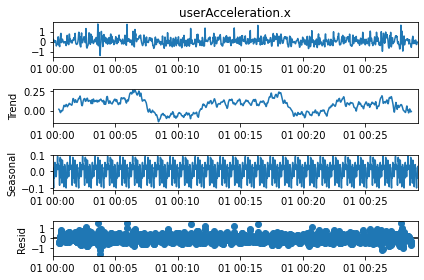

In [13]:
res.plot();

Plot the decomposed time series of `rotationRate.x` also with a frequency of 60.

In [14]:
res2 = seasonal_decompose(sensor["rotationRate.x"], freq = 60, model="additive")

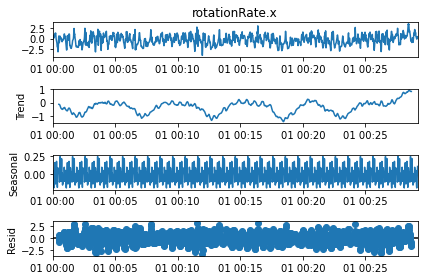

In [15]:
res2.plot();

# Challenge 2 - Modelling the Data

To model our data, we should look at a few assumptions. First, let's plot the `lag_plot` to detect any autocorrelation. Do this for `userAcceleration.x`

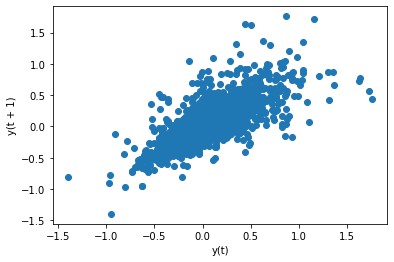

In [16]:
# Your code here:
pd.plotting.lag_plot(sensor["userAcceleration.x"], lag=1);

Create a lag plot for `rotationRate.x`

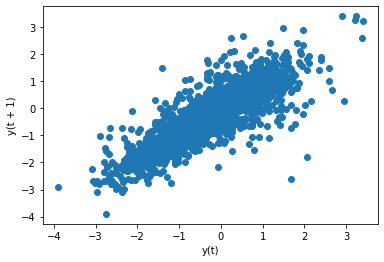

In [17]:
# Your code here:
pd.plotting.lag_plot(sensor["rotationRate.x"], lag=1);

What are your conclusions from both visualizations?

In [18]:
# Your conclusions here:

#Los puntos muestran una fuerte autocorrelación a un instante anterior, que es mucho más fuerte en la de rotación. 

The next step will be to test both variables for stationarity. Perform the Augmented Dickey Fuller test on both variables below.

In [19]:
from statsmodels.tsa.stattools import adfuller


In [30]:
# Your code here:

acce = adfuller(sensor["userAcceleration.x"])
rot = adfuller(sensor["rotationRate.x"])
print(f"ADF for acceleration is {acce[0]} and ADF for rotation is {rot[0]} and their pvalues are {acce[1]} and {rot[1]}")


ADF for acceleration is -17.95799408616975 and ADF for rotation is -5.269860625086409 and their pvalues are 2.823439483037483e-30 and 6.320230335912605e-06


What are your conclusions from this test?

In [22]:
# Your conclusions here:
#Estos resultados muestran que nuestras variables son claramente estacionarias


Finally, we'll create an ARMA model for `userAcceleration.x`. Load the `ARMA` function from `statsmodels`. The order of the model is (2, 1). Split the data to train and test. Use the last 10 observations as the test set and all other observations as the training set. 

In [23]:
# Your code here:
from statsmodels.tsa.arima_model import ARIMA


In [24]:
test = ARIMA(sensor["userAcceleration.x"].iloc[:-10], order=(2,0,1))
test_fit = test.fit()
prediction = test_fit.forecast(10)


C:\Users\cande\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  warnings.warn('No frequency information was'


To compare our predictions with the observed data, we can compute the RMSE (Root Mean Squared Error) from the submodule `statsmodels.tools.eval_measures`. You can read more about this function [here](https://www.statsmodels.org/dev/generated/statsmodels.tools.eval_measures.rmse.html). Compute the RMSE for the last 10 rows of the data by comparing the observed and predicted data for the `userAcceleration.x` column.

In [25]:
# Your code here:
from statsmodels.tools.eval_measures import rmse


In [26]:
rmse(sensor["userAcceleration.x"].iloc[-10:], prediction[0])

0.22529863723338295

In [27]:
for i in range(10):
    print(sensor["userAcceleration.x"].iloc[-10:][i], prediction[0][i])

0.149749 0.17314849878803742
0.038461 0.14289566305592885
-0.169175 0.10052193638763497
-0.300361 0.07010616831156356
-0.270174 0.05609910543211773
-0.268367 0.05377815792182289
-0.102444 0.056790338257341935
-0.08559 0.06064626696746868
-0.048105 0.06331584865967302
-0.065011 0.06449342399286419
